2500
5000
7500
10000
12500
15000
17500
20000
22500
25000
27500
30000
32500
35000
37500
40000
42500
45000
47500
50000
52500
55000
57500
60000
62500
65000
67500
70000
72500
75000
77500
80000
82500
85000
87500
90000
92500
95000
97500
100000
train - yes done
102500
105000
107500
110000
112500
115000
117500
120000
122500
125000
127500
130000
132500
135000
137500
140000
142500
145000
147500
150000
152500
155000
157500
160000
162500
165000
167500
170000
172500
175000
177500
180000
182500
185000
187500
190000
192500
195000
197500
200000
train - no done


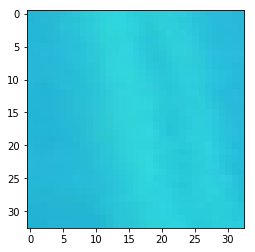

In [73]:
import os
import random
import cv2 as cv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def bgr2rgb(img):
    return img[...,::-1]

def load_color_img(path):
    return np.array( bgr2rgb(cv.imread(path)), dtype=np.float32 )

def load_color_img2(path):
    img = cv.imread(path)
    return img.transpose(2, 1, 0)

random.seed(3)

data_path = os.getcwd() + "/eye_data" + "/set1"
eyes_path = data_path + "/images" + "/"
vessels_path = data_path + "/vessels" + "/"

yes_path = data_path + "/classes/yes_original" + "/"
no_path = data_path + "/classes/no_original" + "/"

yeses = os.listdir(yes_path)
noes = os.listdir(no_path)

random.shuffle(yeses)
random.shuffle(noes)

yeses = yeses[:100000]
noes = noes[:100000]

test = load_color_img(yes_path + yeses[0])
height = test.shape[0]
width = test.shape[1]
channels = test.shape[2]

labels = {
    'yes' : 1,
    'no' : 0
}

train_x = []
train_y = []

sess = tf.Session()
sess.run(tf.global_variables_initializer())

N = len(yeses) + len(noes)
train_x = np.empty((N, height, width, channels), dtype=np.float32)
train_y = np.empty(N, dtype=np.uint8)

idx = 0
for file in yeses:
    
    im = load_color_img(yes_path+file)
    #im_s = sess.run(tf.image.per_image_standardization(im))
    
    train_x[idx] = im
    train_y[idx] = 1
    idx+=1

    if idx % 2500 == 0:
        print(idx)
print('train - yes done')

for file in noes:
    
    im = load_color_img(no_path+file)
    #im_s = sess.run(tf.image.per_image_standardization(im))
    
    train_x[idx] = im
    train_y[idx] = 0
    idx += 1

    if idx % 2500 == 0:
        print(idx)
print('train - no done')

mean_img = np.average(train_x, axis=(1, 2))
std_dev_img = np.std(train_x, axis=(1, 2))
std_dev_img[std_dev_img == 0.0] = 0.00000001

plt.imshow(train_x[10])
plt.show()
for i in range(N):
    for ch in range(3):
        train_x[i, :, :, ch] -= mean_img[i, ch]
        train_x[i, :, :, ch] /= std_dev_img[i, ch]

#for i in range(N):
#    print(train_x[i].shape, mean_img.shape)
#    train_x[i] -= mean_img
#    train_x[i] /= std_dev_im

#train_x /= 255.0
#test_x /= 255.0

In [74]:
from keras.utils import to_categorical

train_y_cat = to_categorical(train_y)
train_y_cat.shape


(200000, 2)

In [ ]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_label, valid_label = train_test_split(train_x, train_y_cat, test_size=0.2, random_state=13)
train_x.shape, valid_x.shape

((160000, 33, 33, 3), (40000, 33, 33, 3))

In [ ]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint

batch_size = 64
epochs = 150
num_classes = len(labels)
input_shape = train_x[0].shape

fashion_model = Sequential()

fashion_model.add(Conv2D(48, kernel_size=(3, 3),activation='relu',padding='same',input_shape=input_shape))
#fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(BatchNormalization())
#fashion_model.add(Dropout(0.25))
#fashion_model.add(MaxPooling2D((2, 2),padding='same'))

fashion_model.add(Conv2D(48, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU())
fashion_model.add(BatchNormalization())
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Dropout(0.25))

fashion_model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
#fashion_model.add(LeakyReLU())
fashion_model.add(BatchNormalization())
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.25))

fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU())     
fashion_model.add(BatchNormalization())
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.25))

fashion_model.add(Flatten())
fashion_model.add(Dense(428, activation='relu'))
#fashion_model.add(BatchNormalization())
fashion_model.add(Dropout(0.25))
fashion_model.add(Dense(num_classes, activation='softmax'))

fashion_model.compile(loss=keras.losses.categorical_crossentropy, 
                      optimizer=keras.optimizers.Adam(),
                      metrics=['accuracy'])

filepath = data_path + "/models/" + "weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

fashion_model.summary()
fashion_train = fashion_model.fit(train_x, train_label, 
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  verbose=1,
                                  callbacks=callbacks_list,
                                  validation_data=(valid_x, valid_label))
fashion_model.save("originalSizeModel - new.h5")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 33, 33, 48)        1344      
_________________________________________________________________
batch_normalization_17 (Batc (None, 33, 33, 48)        192       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 33, 33, 48)        20784     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 33, 33, 48)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 33, 33, 48)        192       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 17, 17, 48)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 17, 17, 48)        0         
__________